In [1]:
import os
import requests
import pandas as pd
from astropy.io import fits
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
from scipy.optimize import minimize
from scipy.interpolate import RectBivariateSpline
import emcee
import corner
import scipy.io as sio
from ipywidgets import FloatProgress
from IPython.display import display
from scipy.integrate import trapz
import time

In [2]:
stellarCatalog = "../stellarCatalogs/dr25_stellar_supp_gaia_clean_notimeout_GKM.txt"
pcCatalog = "koiCatalogs/dr25_GKM_PCs_notimeout.csv"

period_rng = (10, 500)
n_period = 101
rp_rng = (2.5, 5)
n_rp = 101

# for quick tests
#nWalkers = 8
#nBurnin = 200
#nMcmc = 1000
# for production runs
nWalkers = 100
nBurnin = 1000
nMcmc = 2000


model = "dualPowerLaw"
# which Radii lets you try with planet radii corrected for Gaia radii (whichRadii = "corrected")
# or with original KOI table planet radii (whichRadii = "kic")
whichRadii = "corrected"

In [3]:
def rateModel(x, y, xRange, yRange, theta, model):
    if model == "dualPowerLaw":
        f0, alpha, beta = theta
        ap1 = alpha+1;
        bp1 = beta+1;
        r = f0*(ap1*(x**alpha)/(xRange[1]**ap1-xRange[0]**ap1))*(bp1*(y**beta)/(yRange[1]**bp1-yRange[0]**bp1))
    else:
        raise ValueError('Bad model name');      
    return r

def getModelLabels(model):
    if model == "dualPowerLaw":
        return [r"$F_0$", r"$\beta$", r"$\alpha$"]
    else:
        raise ValueError('Bad model name');

def initRateModel(model):
    if model == "dualPowerLaw":
        f0 = 1
        alpha = 1
        beta = 1
        theta = [f0, alpha, beta]
    else:
        raise ValueError('Bad model name');
  
    return theta

def lnPoisprior(theta, model):
    if model == "dualPowerLaw":
        if 0.0 <= theta[0] <= 5 \
        and -5.0 <= theta[1] <= 5.0 \
        and -6.0 <= theta[2] <= 5.0:
            return 1.0
    else:
        raise ValueError('Bad model name');
        
    # print(theta)
    return -np.inf

In [4]:
def medianAndErrorbars(data):
    if data.ndim > 1:
        dataResult = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(data, [16, 50, 84],
                                                axis=0)))
        dataResult = list(dataResult)
        return dataResult
    else:
        v = np.percentile(data, [16, 50, 84])
        return [v[1], v[2]-v[1], v[1]-v[0]]

def printMedianAndErrorbars(data):
    e = medianAndErrorbars(data)
    if data.ndim > 1:
        print("printMedianAndErrorbars only works for 1D arrays")
    else:
        return "{:.3f}".format(e[0]) +"^{+" + "{:.3f}".format(e[1]) + "}_{-" + "{:.3f}".format(e[2]) + "}"

In [5]:
from scipy.integrate import romb

def integrate2DGrid(g, dx, dy):
    #if g.shape[0]%2 == 0 or g.shape[1]%2 == 0:
    #    raise ValueError('integrate2DGrid requires a grid with odd number of points on a side');
    return trapz(trapz(g, dx=dx), dx=dy)

def integrateRateModel(periodRange, rpRange, theta, model):
    nPts = 5
    pGrid, rGrid = np.meshgrid(np.linspace(start=periodRange[0], stop=periodRange[1], num=nPts), 
                                np.linspace(start=rpRange[0], stop=rpRange[1], num=nPts), indexing="ij")
    dp = (pGrid[1,0]-pGrid[0,0])
    dr = (rGrid[0,1]-rGrid[0,0])
    
    if theta.ndim == 1:
        y = rateModel(pGrid, rGrid, period_rng, rp_rng, theta, model)
        return integrate2DGrid(y, dp, dr)
    else: # assume first dimension is array of thetas
        ret = np.zeros(theta.shape[0])
        if len(ret) > 100:
            f = FloatProgress(min=0, max=len(ret))
            display(f)

        for i in range(len(ret)):
            y = rateModel(pGrid, rGrid, period_rng, rp_rng, theta[i,:], model)
            ret[i] = integrate2DGrid(y, dp, dr)
            if len(ret) > 100:
                f.value += 1
        return ret

def integratePopTimesComp(periodRange, rpRange, theta, model, compGrid):
    nP = compGrid.shape[0]
    nR = compGrid.shape[1]

    pGrid, rGrid = np.meshgrid(np.linspace(periodRange[0], periodRange[1], nP), 
                                       np.linspace(rpRange[0], rpRange[1], nR), 
                                       indexing="ij")
    dp = (pGrid[1,0]-pGrid[0,0])
    dr = (rGrid[0,1]-rGrid[0,0])
    y = rateModel(pGrid, rGrid, period_rng, rp_rng, theta, model)*compGrid
    return integrate2DGrid(y, dp, dr)

In [6]:
# population inference functions
def lnlike(theta):
    pop = rateModel(period_grid, rp_grid, period_rng, rp_rng, theta, model) * summedCompleteness
    pop = 0.5 * (pop[:-1, :-1] + pop[1:, 1:])
    norm = np.sum(pop * vol)
    ll = np.sum(np.log(rateModel(koi_periods, koi_rps, period_rng, rp_rng, theta, model))) - norm
    return ll if np.isfinite(ll) else -np.inf

# The ln-probability function is just propotional to the ln-likelihood
# since we're assuming uniform priors.
def lnprob(theta):
    lp = lnPoisprior(theta, model)
    if not np.isfinite(lp):
        return -np.inf

    return lnlike(theta)

# The negative ln-likelihood is useful for optimization.
# Optimizers want to *minimize* your function.
def nll(theta):
    ll = lnlike(theta)
    return -ll if np.isfinite(ll) else 1e15

In [7]:
def getRadii(catalog):
    if whichRadii == "corrected":
        return catalog.corrected_prad
    elif whichRadii == "kic":
        return catalog.koi_prad
    else:
        raise ValueError('Bad whichRadii string')

In [8]:
stellarTargets = pd.read_csv(stellarCatalog)
base_kois = pd.read_csv(pcCatalog)
m = (period_rng[0] <= base_kois.koi_period) & (base_kois.koi_period <= period_rng[1])
thisRadii = getRadii(base_kois)
m &= np.isfinite(thisRadii) & (rp_rng[0] <= thisRadii) & (thisRadii <= rp_rng[1])
    
kois = pd.DataFrame(base_kois[m])
allKois = kois

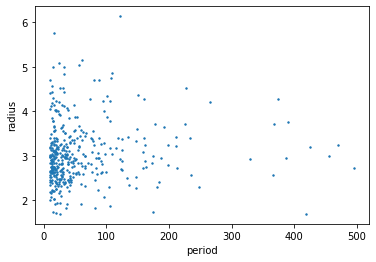

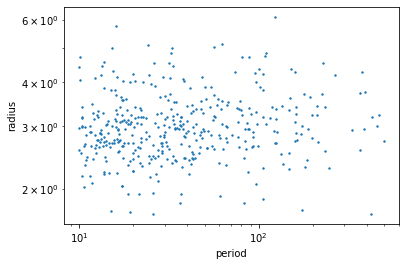

In [9]:
plt.figure()
plt.scatter(kois.koi_period, kois.koi_prad, s=2)
#plt.ylim(0, 5)
plt.xlabel('period')
plt.ylabel('radius')

plt.figure()
plt.scatter(kois.koi_period, kois.koi_prad, s=2)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('period')
plt.ylabel('radius')
plt.show()

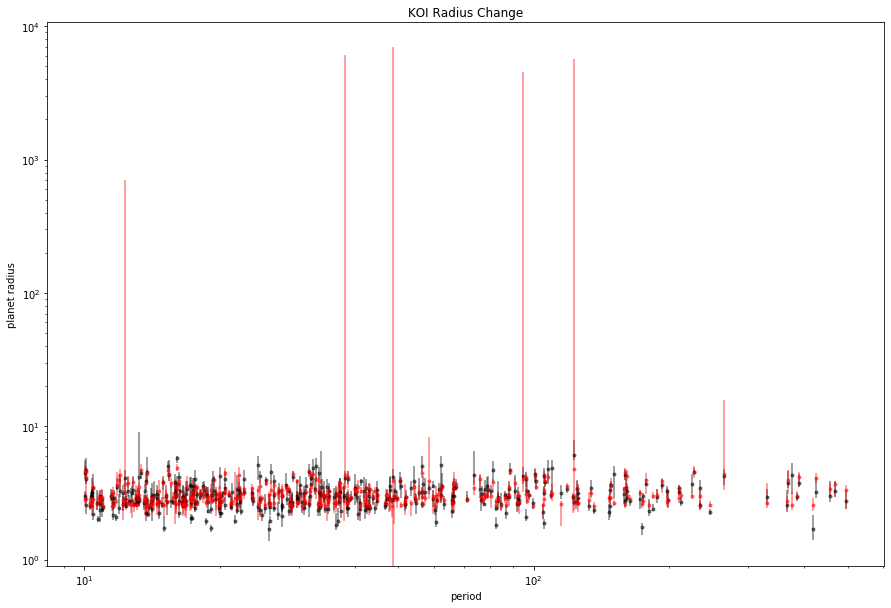

In [10]:
fig, ax = plt.subplots(figsize=(15,10))
ax.errorbar(kois.koi_period, kois.koi_prad, 
            yerr = [-kois.koi_prad_err2, kois.koi_prad_err1],
            fmt="k.", alpha = 0.5)
ax.errorbar(kois.koi_period, kois.corrected_prad, 
            yerr = [-kois.corrected_prad_err2, kois.corrected_prad_err1],
            fmt="r.", alpha = 0.5)

plt.xlabel("period")
plt.ylabel("planet radius")
plt.title("KOI Radius Change")
plt.yscale('log')
plt.xscale('log')
plt.show()

In [42]:
period = np.linspace(period_rng[0], period_rng[1], num=5)
rp = np.linspace(rp_rng[0], rp_rng[1], num=5)
period_grid, rp_grid = np.meshgrid(period, rp, indexing="ij")
periodShape = period_grid.shape

#period = np.logspace(np.log10(10), np.log10(700), num=5)
#rp = np.logspace(np.log10(2.5), np.log10(5), num=6)
#period_grid, rp_grid = np.meshgrid(period, rp, indexing="ij")
#periodShape = period_grid.shape

In [43]:
inputgrid = "../completenessContours/out0603_sc0_GKM_baseline.fits.gz"

hdulist = fits.open(inputgrid)
cumulative_array = hdulist[0].data
kiclist = np.asarray(hdulist[1].data, dtype=np.int32)
probdet = np.transpose(cumulative_array[0])
probtot = np.transpose(cumulative_array[1])
prihdr = hdulist[0].header
min_comp_period = prihdr["MINPER"]
max_comp_period = prihdr["MAXPER"]
n_comp_period = prihdr["NPER"]
min_comp_rp = prihdr["MINRP"]
max_comp_rp = prihdr["MAXRP"]
n_comp_rp = prihdr["NRP"]
# print "KIC list length" + '{:6d}'.format(kiclist.size)
print(hdulist[0].header,)

period_want = np.linspace(min_comp_period, max_comp_period, n_comp_period)
rp_want = np.linspace(min_comp_rp, max_comp_rp, n_comp_rp)
period_want2d, rp_want2d = np.meshgrid(period_want, rp_want)

numCompVeInterp = RectBivariateSpline(period_want, rp_want, probtot)
numProbDetInterp = RectBivariateSpline(period_want, rp_want, probdet)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                 1000                                                  NAXIS2  =                 1000                                                  NAXIS3  =                    2                                                  EXTEND  =                    T                                                  MINPER  =                 10.0                                                  MAXPER  =                500.0                                                  NPER    =                 1000                                                  MINRP   =                  2.5                                                  MAXRP   =                  6.0                                                  NRP     =                 1000          

In [44]:
summedCompleteness = numCompVeInterp(period, rp)
summedProbDet = numProbDetInterp(period, rp)

In [45]:
print(summedCompleteness.shape)
print(summedProbDet.shape)

(5, 5)
(5, 5)


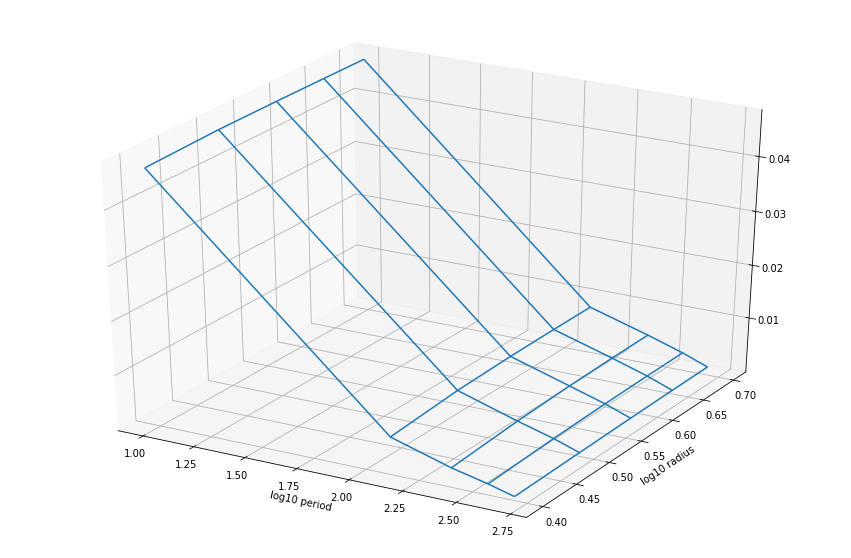

In [46]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')

logp = np.log10(period_grid)
logr = np.log10(rp_grid)

cut_logp = logp.copy()
#cut_logp[np.where(cut_logp > 2)] = np.nan

cut_logr = logr.copy()
#cut_logr[np.where(cut_logr < -0.1)] = np.nan


ax.plot_wireframe(cut_logp, cut_logr, summedCompleteness / kiclist.size)
#ax.plot_surface(period_grid, rp_grid, summedProbDet)
#plt.xlim(0,100)  
#plt.ylim(0,1)  
ax.set_xlabel('log10 period')
ax.set_ylabel('log10 radius')
plt.show()

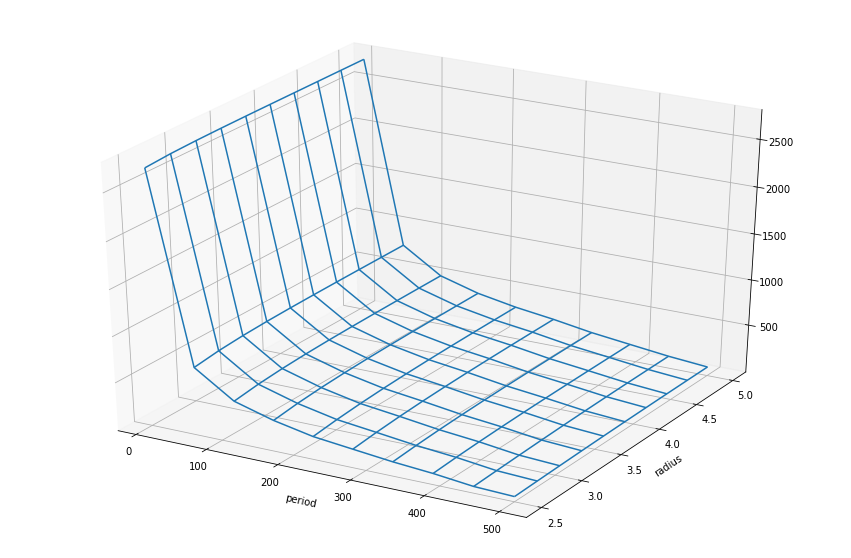

In [16]:
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')

#ax.plot_wireframe(period_grid, rp_grid, summedCompleteness / kiclist.size, rstride=2, cstride=2)
ax.plot_wireframe(period_grid, rp_grid, summedCompleteness)
ax.set_xlabel('period')
ax.set_ylabel('radius')
plt.show()

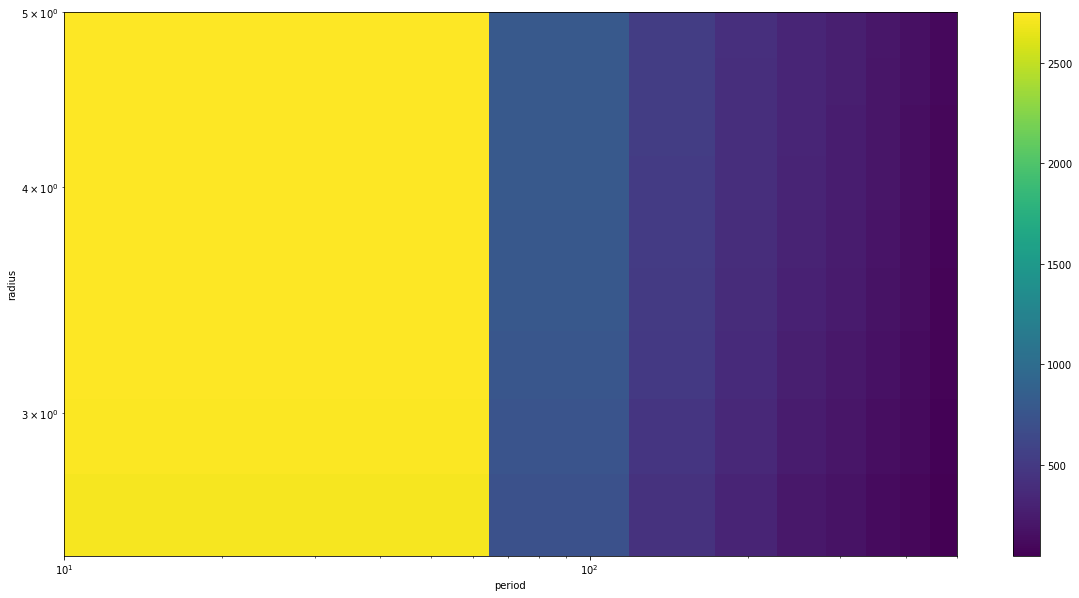

In [17]:
fig, ax = plt.subplots(figsize=(20, 10))
#ax = fig.add_subplot(132)
im = ax.pcolormesh(period_grid, rp_grid, summedCompleteness)
#plt.xlim(.1,500)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('period')
plt.ylabel('radius')
fig.colorbar(im)
plt.show()

In [18]:
# population analysis functions modified from Daniel Foreman Mackey's https://dfm.io/posts/exopop/

# We'll reuse these functions to plot all of our results.
def make_plot(pop_comp, x0, x, y, ax):
    #print("in make_plot, pop_comp:")
    #print(pop_comp.shape)

    pop = 0.5 * (pop_comp[:, 1:] + pop_comp[:, :-1])
    #print("pop:")
    #print(pop.shape)
    pop = np.sum(pop * np.diff(y)[None, :, None], axis=1)
    #print(pop.shape)
    a, b, c, d, e = np.percentile(pop * np.diff(x)[0], [2.5, 16, 50, 84, 97.5], axis=0)
    #print(c.shape)
    
    ax.fill_between(x0, a, e, color="k", alpha=0.1, edgecolor="none")
    ax.fill_between(x0, b, d, color="k", alpha=0.3, edgecolor="none")
    ax.plot(x0, c, "k", lw=1)

def plot_results(samples):
    #  Loop through the samples and compute the list of population models.
    samples = np.atleast_2d(samples)
    pop = np.empty((len(samples), period_grid.shape[0], period_grid.shape[1]))
    gamma_earth = np.empty((len(samples)))

    for i, p in enumerate(samples):
        pop[i] = rateModel(period_grid, rp_grid, period_rng, rp_rng, p, model)
        gamma_earth[i] = rateModel(365.25, 1.0, period_rng, rp_rng, p, model) * 365.
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    fig.subplots_adjust(wspace=0.4, hspace=0.4)
    
    # Integrate over period.
    dx = 0.25
    x = rp.copy()
    n, _ = np.histogram(koi_rps, x)
    
    fsize = 18
    # Plot the observed radius distribution.
    ax = axes[0, 0]
    make_plot(pop * summedCompleteness[None, :, :], rp, x, period, ax)
    ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k",
                capsize=0)
    #ax.set_xlim(rp_rng[0], rp_rng[1])
    ax.set_xlabel("$R_p\,[R_\oplus]$", fontsize = fsize)
    ax.set_ylabel("# of detected planets", fontsize = fsize)
    
    # Plot the true radius distribution.
    ax = axes[0, 1]
    make_plot(pop, rp, x, period, ax)
    #ax.set_xlim(rp_rng[0], rp_rng[1])
    #ax.set_ylim(0, 0.37)
    ax.set_xlabel("$R_p\,[R_\oplus]$", fontsize = fsize)
    ax.set_ylabel("$\mathrm{d}N / \mathrm{d}R$; $\Delta R = 0.25\,R_\oplus$", fontsize = fsize)
    
    # Integrate over period.
    dx = 31.25
    x = period.copy()
    n, _ = np.histogram(koi_periods, x)
    
    # Plot the observed period distribution.
    ax = axes[1, 0]
    make_plot(np.swapaxes(pop * summedCompleteness[None, :, :], 1, 2), period, x, rp, ax)
    ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k",
                capsize=0)
    #ax.set_xlim(period_rng[0], period_rng[1])
    #ax.set_ylim(0, 79)
    ax.set_xlabel("$P\,[\mathrm{days}]$", fontsize = fsize)
    ax.set_ylabel("# of detected planets", fontsize = fsize)
    
    # Plot the true period distribution.
    ax = axes[1, 1]
    make_plot(np.swapaxes(pop, 1, 2), period, x, rp, ax)
    #ax.set_xlim(period_rng[0], period_rng[1])
    #ax.set_ylim(0, 0.27)
    ax.set_xlabel("$P\,[\mathrm{days}]$", fontsize = fsize)
    ax.set_ylabel("$\mathrm{d}N / \mathrm{d}P$; $\Delta P = 31.25\,\mathrm{days}$", fontsize = fsize)
    
                
    return gamma_earth, fig

Compute a basic occurrence rate without reliability

[1, 1, 1]
3938.7727658021786
[ 0.69016918 -0.15345187 -4.44689656]


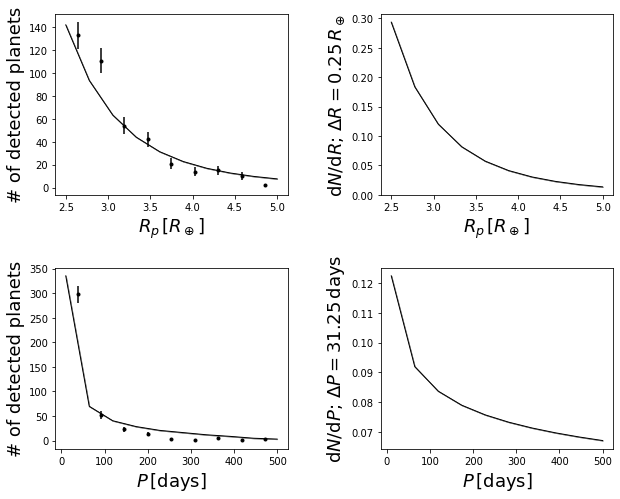

In [19]:
kois = allKois

if model == "dualPowerLaw":
    bounds = [(0, 5), (-5, 5), (-6, 5)]
    
# The ln-likelihood function given at the top of this post.
koi_periods = np.array(kois.koi_period)
koi_rps = np.array(getRadii(kois))
# koi_rps = getRadii(kois)

vol = np.diff(period_grid, axis=0)[:, :-1] * np.diff(rp_grid, axis=1)[:-1, :]

theta_0 = initRateModel(model)
#theta_0 = [5, 1, 5]
print(theta_0)
print(nll(theta_0))
r = minimize(nll, theta_0, method="L-BFGS-B", bounds=bounds)
print(r.x)
ge, fig = plot_results(r.x)
#[ 0.88074391 -0.50150404  0.11076642]

In [20]:

##################################################################
ndim, nwalkers = len(r.x), nWalkers
pos = [r.x + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=8)

# Burn in.
pos, _, _ = sampler.run_mcmc(pos, nBurnin)
sampler.reset()

# Production.
start_time = time.time()
pos, _, _ = sampler.run_mcmc(pos, nMcmc)
print("--- %s seconds ---" % (time.time() - start_time))

samples_noreliability = sampler.flatchain

--- 16.348201990127563 seconds ---


44.475783579541584


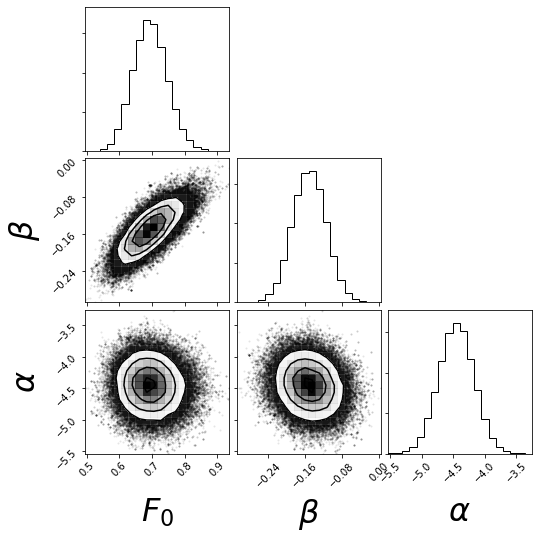

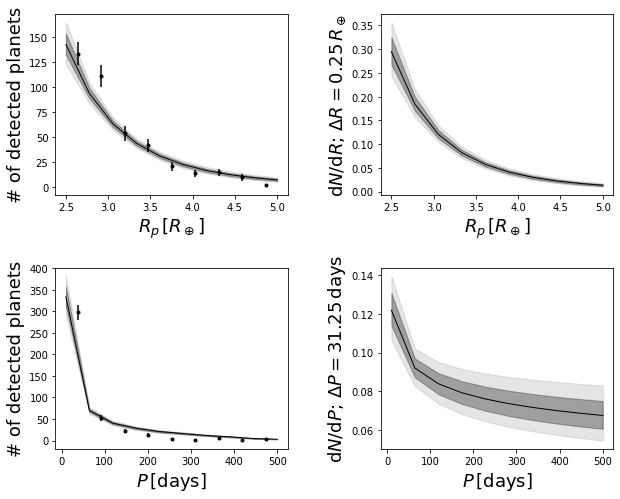

In [21]:
##################################################################
##################################################################

corner.corner(samples_noreliability, labels=getModelLabels(model), label_kwargs = {"fontsize": 32})
#plt.savefig("occPostNoReliability.pdf",bbox_inches='tight')

##################################################################

gamma_earth_no_reliability, fig = plot_results(samples_noreliability)
#plt.savefig("occMargNoReliability.pdf",bbox_inches='tight')
print(np.mean(gamma_earth_no_reliability))

##################################################################

Compute an occurrence rate with reliability

In [22]:
nTrials = 200

f = FloatProgress(min=0, max=nTrials)
display(f)

allKois = kois
for mCount in range(nTrials):
    # randomly select kois
    
    koiSelect = (np.random.rand(len(allKois)) < allKois.totalReliability)
#    koiSelect = (np.random.rand(len(allKois)) < allKois.reliability)
    kois = allKois[koiSelect]
#    kois.to_csv("occurenceRatePosteriors/selectedPcs" + str  (mCount) + ".csv")
#    print(str(mCount) + " of " + str(nTrials) + ", selected " + str(len(kois)) 
#          + " kois out of " + str(len(allKois)) + " after reliability cut")
    
    koi_periods = np.array(kois.koi_period)
    koi_rps = np.array(getRadii(kois))

    theta_0 = initRateModel(model)
    r = minimize(nll, theta_0, method="L-BFGS-B", bounds=bounds)

    ##################################################################

    ndim, nwalkers = len(r.x), 2*len(r.x)
    pos = [r.x + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

    # Burn in.
    pos, _, _ = sampler.run_mcmc(pos, 200)
    sampler.reset()

    # Production.
    pos, _, _ = sampler.run_mcmc(pos, 1000)

    samples = sampler.flatchain   
    if mCount == 0:
        allSamples = samples[0:-1:10,:]
    else:
        allSamples = np.concatenate((allSamples, samples[0:-1:10,:]))
    
    f.value += 1

FloatProgress(value=0.0, max=200.0)

/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


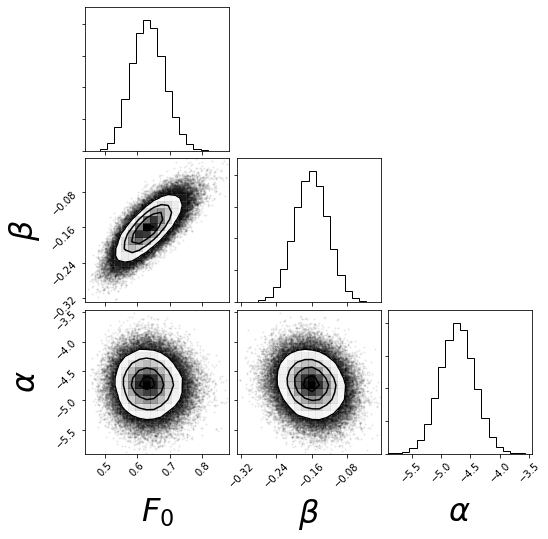

In [23]:
corner.corner(allSamples, labels=getModelLabels(model), label_kwargs = {"fontsize": 32});
#plt.savefig("occPostReliability.pdf",bbox_inches='tight')

In [24]:
modelLabels = getModelLabels(model)
for i in range(0,ndim):
    print("MCMC no reliability " + modelLabels[i] + "=" + printMedianAndErrorbars(samples_noreliability[:,i]))
for i in range(0,ndim):
    print("MCMC with reliability " + modelLabels[i] + "=" + printMedianAndErrorbars(allSamples[:,i]))

MCMC no reliability $F_0$=0.693^{+0.053}_{-0.051}
MCMC no reliability $\beta$=-0.151^{+0.036}_{-0.037}
MCMC no reliability $\alpha$=-4.451^{+0.274}_{-0.281}
MCMC with reliability $F_0$=0.633^{+0.051}_{-0.049}
MCMC with reliability $\beta$=-0.161^{+0.038}_{-0.038}
MCMC with reliability $\alpha$=-4.724^{+0.288}_{-0.294}


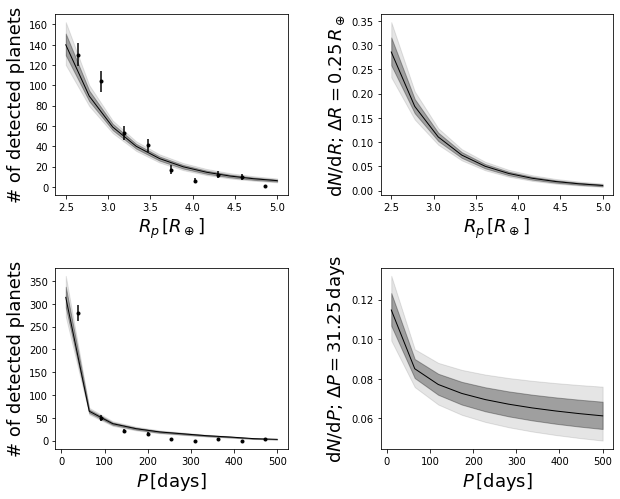

In [25]:
gamma_earth, fig = plot_results(allSamples)
#plt.savefig("occMargReliability.png", bbox_inches='tight')

In [26]:
def dfm(pg, rg, prng, rrng, pbins, rbins, samples, model, comp, cplt=False):
    samples = np.atleast_2d(samples)
    pop = np.empty((len(samples), pg.shape[0], pg.shape[1]))
    for i, p in enumerate(samples):
        pop[i] = rateModel(pg, rg, prng, rrng, p, model)
    #pop = rateModel(pg, rg, prng, rrng, sample, model)
    if cplt:
        pop = pop * comp[None, :, :]
        alt_pop = np.swapaxes(pop, 1, 2)
    else:
        #pop = pop[None, :, :]
        alt_pop = np.swapaxes(pop, 1, 2)
    
    pop = 0.5*(pop[:, 1:] + pop[:, :-1])
    pop = np.sum(pop * np.diff(pbins)[None, :, None], axis=1)
    
    alt_pop = 0.5*(alt_pop[:, 1:] + alt_pop[:, :-1])
    alt_pop = np.sum(alt_pop * np.diff(rbins)[None, :, None], axis=1)
    
    r = np.percentile(pop * np.diff(rbins)[0], [2.5, 16, 50, 84, 97.5], axis=0)
    p = np.percentile(alt_pop * np.diff(pbins)[0], [2.5, 16, 50, 84, 97.5], axis=0)
    
    return(r, p)

def recreate(pg, rg, prng, rrng, pbins, rbins, samples, model, comp, cplt=False):
    samples = np.atleast_2d(samples)
    pop = np.empty((len(samples), pg.shape[0], pg.shape[1]))
    for i, p in enumerate(samples):
        pop[i] = rateModel(pg, rg, prng, rrng, p, model)
    #pop = rateModel(pg, rg, prng, rrng, sample, model)
    if cplt:
        pop = pop * comp[None, :, :]
        alt_pop = np.swapaxes(pop, 1, 2)
    else:
        #pop = pop[None, :, :]
        alt_pop = np.swapaxes(pop, 1, 2)
    
    pop = trapz(pop, x=pbins, axis=1)
    r = np.percentile(pop * np.diff(rbins)[0], [2.5, 16, 50, 84, 97.5], axis=0)
    
    alt_pop = trapz(alt_pop, rbins, axis=1)
    p = np.percentile(alt_pop * np.diff(pbins)[0], [2.5, 16, 50, 84, 97.5], axis=0)
    
    return(r, p)

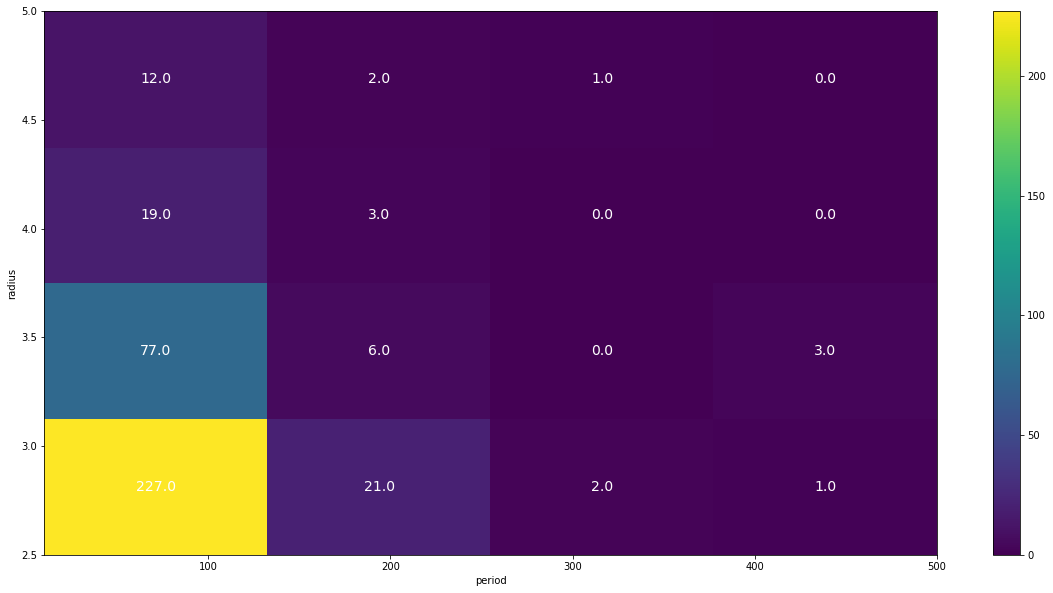

In [47]:
H, xedges, yedges = np.histogram2d(kois.koi_period, getRadii(kois), bins=(period, rp))
xcent = 0.5 * (xedges[1:] + xedges[:-1])
ycent = 0.5 * (yedges[1:] + yedges[:-1])

#X, Y = np.meshgrid(xedges, yedges)
fig, ax = plt.subplots(figsize=(20, 10))
#ax = fig.add_subplot(132)
im = ax.pcolormesh(period_grid, rp_grid, H)

for i in range(len(yedges)-1):
    for j in range(len(xedges)-1):
        ax.text(xcent[j],ycent[i], H.T[i,j], 
                color="white", ha="center", va="center", fontsize=14)

#plt.xlim(.1,500)
plt.xlabel('period')
plt.ylabel('radius')
fig.colorbar(im)
#plt.savefig("10hist_p10500r255.png")
plt.show()

In [48]:
p_cent = 0.5* (period[1:] + period[:-1])
r_cent = 0.5* (rp[1:] + rp[:-1])

In [49]:
dfm_rad, dfm_per = dfm(period_grid, rp_grid, period_rng, rp_rng, period, rp, 
                        allSamples, model, summedCompleteness)
rad, per = recreate(period_grid, rp_grid, period_rng, rp_rng, period, rp, 
                     allSamples, model, summedCompleteness)

dfm_rad_num, dfm_per_num = dfm(period_grid, rp_grid, period_rng, rp_rng, period, rp, 
                        allSamples, model, summedCompleteness, cplt=True)
rad_num, per_num = recreate(period_grid, rp_grid, period_rng, rp_rng, period, rp, 
                     allSamples, model, summedCompleteness, cplt=True)

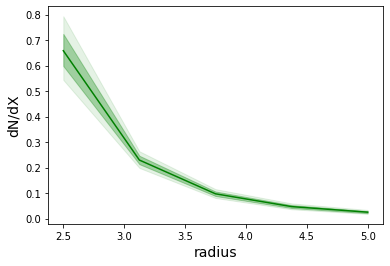

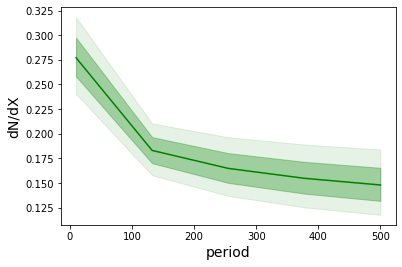

In [50]:
plt.figure()
#plt.fill_between(rp, dfm_rad[0], dfm_rad[4], color="m", alpha=0.1, edgecolor="none")
#plt.fill_between(rp, dfm_rad[1], dfm_rad[3], color="m", alpha=0.3, edgecolor="none")
#plt.plot(rp, dfm_rad[2], label='dfm, radius', linestyle='--', color='m')
plt.fill_between(rp, rad[0], rad[4], color="g", alpha=0.1, edgecolor="none")
plt.fill_between(rp, rad[1], rad[3], color="g", alpha=0.3, edgecolor="none")
plt.plot(rp, rad[2], color='g', label='mine, radius')
#plt.legend()
plt.ylabel("dN/dX", fontsize=14)
plt.xlabel("radius", fontsize=14)

plt.figure()
#plt.fill_between(period, dfm_per[0], dfm_per[4], color="m", alpha=0.1, edgecolor="none")
#plt.fill_between(period, dfm_per[1], dfm_per[3], color="m", alpha=0.3, edgecolor="none")
#plt.plot(period, dfm_per[2], label='dfm, period', linestyle='--', color='m')
plt.fill_between(period, per[0], per[4], color="g", alpha=0.1, edgecolor="none")
plt.fill_between(period, per[1], per[3], color="g", alpha=0.3, edgecolor="none")
plt.plot(period, per[2], color='g', label='mine, period')
#plt.legend()
plt.ylabel("dN/dX", fontsize=14)
plt.xlabel("period", fontsize=14)

plt.show()

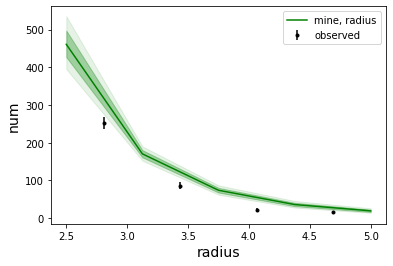

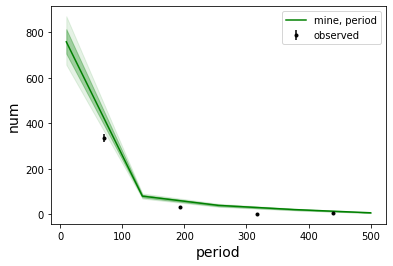

In [51]:
plt.figure()
#plt.fill_between(rp, dfm_rad_num[0], dfm_rad_num[4], color="m", alpha=0.1, edgecolor="none")
#plt.fill_between(rp, dfm_rad_num[1], dfm_rad_num[3], color="m", alpha=0.3, edgecolor="none")
#plt.plot(rp, dfm_rad_num[2], label='dfm, radius', linestyle='--', color='m')
plt.fill_between(rp, rad_num[0], rad_num[4], color="g", alpha=0.1, edgecolor="none")
plt.fill_between(rp, rad_num[1], rad_num[3], color="g", alpha=0.3, edgecolor="none")
plt.plot(rp, rad_num[2], color='g', label='mine, radius')

plt.errorbar(r_cent, np.sum(H, axis=0), yerr=np.sqrt(np.sum(H, axis=0)), fmt=".k", label='observed')

plt.legend()
plt.ylabel("num", fontsize=14)
plt.xlabel("radius", fontsize=14)

plt.figure()
#plt.fill_between(period, dfm_per_num[0], dfm_per_num[4], color="m", alpha=0.1, edgecolor="none")
#plt.fill_between(period, dfm_per_num[1], dfm_per_num[3], color="m", alpha=0.3, edgecolor="none")
#plt.plot(period, dfm_per_num[2], label='dfm, period', linestyle='--', color='m')
plt.fill_between(period, per_num[0], per_num[4], color="g", alpha=0.1, edgecolor="none")
plt.fill_between(period, per_num[1], per_num[3], color="g", alpha=0.3, edgecolor="none")
plt.plot(period, per_num[2], color='g', label='mine, period')

plt.errorbar(p_cent, np.sum(H, axis=1), yerr=np.sqrt(np.sum(H, axis=1)), fmt=".k", label='observed')

plt.legend()
plt.ylabel("num", fontsize=14)
plt.xlabel("period", fontsize=14)

plt.show()

In [52]:
from scipy.interpolate import griddata
points = np.array(list(zip(period_grid.flatten(), rp_grid.flatten())))
values = summedCompleteness.flatten()

pc = np.array(list(zip(kois.koi_period.values, getRadii(kois).values)))

grid = griddata(points, values, pc, method='linear')
#print(grid)

In [53]:
kois['completeness'] = grid/ kiclist.size
kois['kois_rp'] = getRadii(kois)

/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [54]:
occ = np.zeros((len(period)-1, len(rp)-1))

for i in range(len(period)-1):
    for j in range(len(rp)-1):
        #print(i, j)
        #print([period[i], period[i+1]], [rp[j], rp[j+1]])
        bin_ = kois[((kois.koi_period < period[i+1]) & (kois.koi_period > period[i]) & 
                     (kois.kois_rp < rp[j+1]) & (kois.kois_rp > rp[j]))]
        occ[i, j] = np.sum(bin_.totalReliability / bin_.completeness) / kiclist.size
        
print(occ)

[[0.11095997 0.03725057 0.01046672 0.00496294]
 [0.06223337 0.01265587 0.00668924 0.00507258]
 [0.01561945 0.         0.         0.0017637 ]
 [0.00710538 0.03677652 0.         0.        ]]


In [55]:
b = kois[((kois.koi_period < 40) & (kois.koi_period > 10) & 
                     (kois.kois_rp < 5) & (kois.kois_rp > 2.5))]
np.sum(b.totalReliability / b.completeness) / kiclist.size

0.08787003872781564

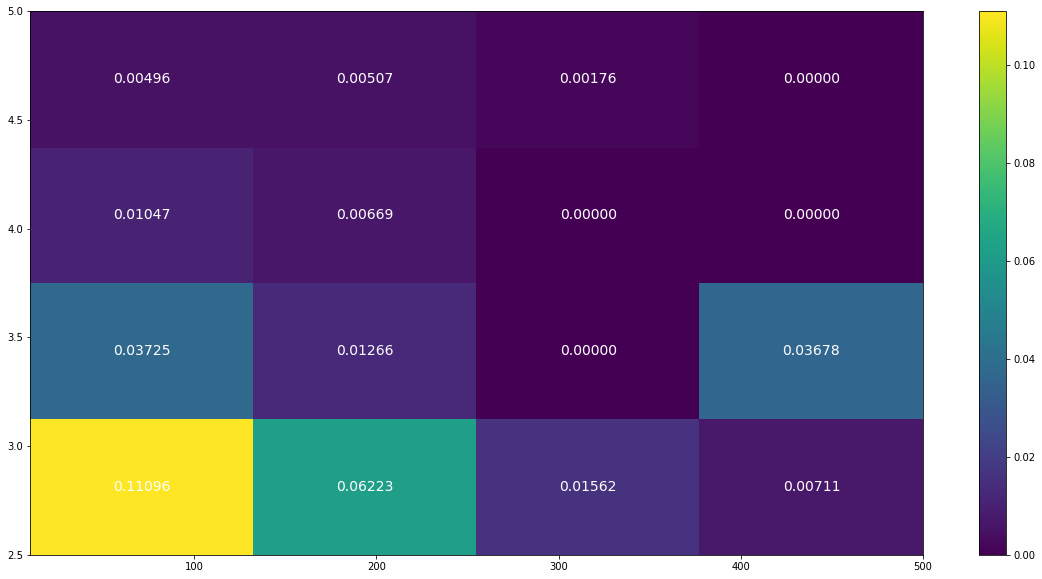

In [56]:
fig, ax = plt.subplots(figsize=(20,10))
im = ax.pcolormesh(period_grid, rp_grid, occ)
for i in range(len(yedges)-1):
    for j in range(len(xedges)-1):
        ax.text(xcent[j],ycent[i], str("%.5f" % occ.T[i,j]), 
                color="white", ha="center", va="center", fontsize=14)

plt.colorbar(im)
#plt.savefig('10occhist_p10500r255.png')
plt.show()

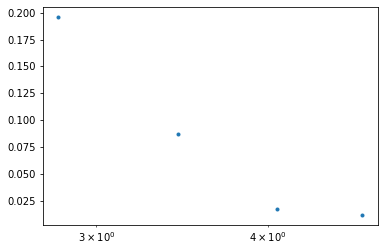

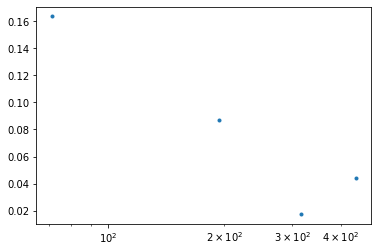

In [57]:
plt.figure()
plt.plot(r_cent, np.sum(occ, axis=0), '.')
plt.xscale('log')

plt.figure()
plt.plot(p_cent, np.sum(occ, axis=1), '.')
plt.xscale('log')

plt.show()

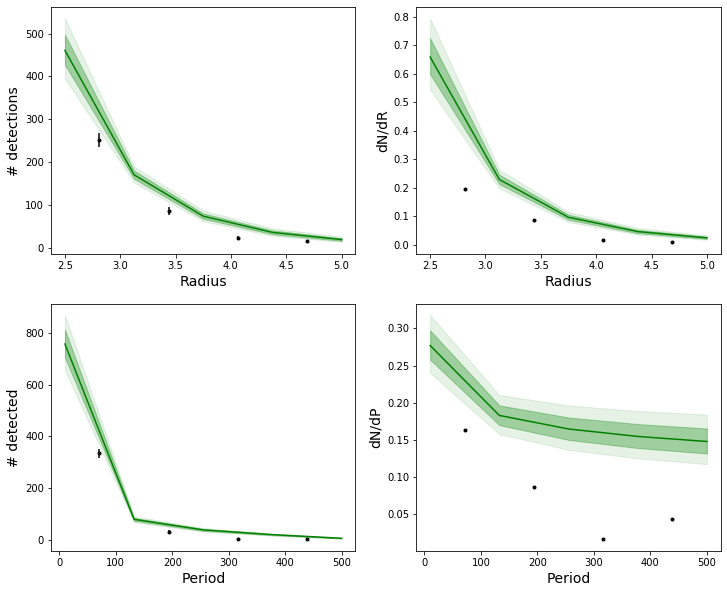

In [58]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

#axs[0, 0].fill_between(rp, dfm_rad_num[0], dfm_rad_num[4], color="m", alpha=0.1, edgecolor="none")
#axs[0, 0].fill_between(rp, dfm_rad_num[1], dfm_rad_num[3], color="m", alpha=0.3, edgecolor="none")
#axs[0, 0].plot(rp, dfm_rad_num[2], label='dfm, radius', linestyle='--', color='m')
axs[0, 0].fill_between(rp, rad_num[0], rad_num[4], color="g", alpha=0.1, edgecolor="none")
axs[0, 0].fill_between(rp, rad_num[1], rad_num[3], color="g", alpha=0.3, edgecolor="none")
axs[0, 0].plot(rp, rad_num[2], color='g', label='mine, radius')
axs[0, 0].errorbar(r_cent, np.sum(H, axis=0), yerr=np.sqrt(np.sum(H, axis=0)), fmt=".k", label='observed')
axs[0, 0].set_xlabel('Radius', fontsize=14)
axs[0, 0].set_ylabel('# detections', fontsize=14)
#axs[0,0].legend()

#axs[0, 1].fill_between(rp, dfm_rad[0], dfm_rad[4], color="m", alpha=0.1, edgecolor="none")
#axs[0, 1].fill_between(rp, dfm_rad[1], dfm_rad[3], color="m", alpha=0.3, edgecolor="none")
#axs[0, 1].plot(rp, dfm_rad[2], label='dfm, radius', linestyle='--', color='m')
axs[0, 1].fill_between(rp, rad[0], rad[4], color="g", alpha=0.1, edgecolor="none")
axs[0, 1].fill_between(rp, rad[1], rad[3], color="g", alpha=0.3, edgecolor="none")
axs[0, 1].plot(rp, rad[2], color='g', label='mine, radius')
axs[0, 1].scatter(r_cent, np.sum(occ, axis=0), marker='.', color='k') 
axs[0, 1].set_xlabel('Radius', fontsize=14)
axs[0, 1].set_ylabel('dN/dR', fontsize=14)
#axs[0,1].legend()

#axs[1, 1].fill_between(period, dfm_per[0], dfm_per[4], color="m", alpha=0.1, edgecolor="none")
#axs[1, 1].fill_between(period, dfm_per[1], dfm_per[3], color="m", alpha=0.3, edgecolor="none")
#axs[1, 1].plot(period, dfm_per[2], label='dfm, period', linestyle='--', color='m')
axs[1, 1].fill_between(period, per[0], per[4], color="g", alpha=0.1, edgecolor="none")
axs[1, 1].fill_between(period, per[1], per[3], color="g", alpha=0.3, edgecolor="none")
axs[1, 1].plot(period, per[2], color='g', label='mine, period')
axs[1, 1].scatter(p_cent, np.sum(occ, axis=1), marker='.', color='k') 
axs[1, 1].set_xlabel('Period', fontsize=14)
axs[1, 1].set_ylabel('dN/dP', fontsize=14)
#axs[1,1].legend()

#axs[1,0].fill_between(period, dfm_per_num[0], dfm_per_num[4], color="m", alpha=0.1, edgecolor="none")
#axs[1,0].fill_between(period, dfm_per_num[1], dfm_per_num[3], color="m", alpha=0.3, edgecolor="none")
#axs[1,0].plot(period, dfm_per_num[2], label='dfm, period', linestyle='--', color='m')
axs[1,0].fill_between(period, per_num[0], per_num[4], color="g", alpha=0.1, edgecolor="none")
axs[1,0].fill_between(period, per_num[1], per_num[3], color="g", alpha=0.3, edgecolor="none")
axs[1,0].plot(period, per_num[2], color='g', label='mine, period')
axs[1,0].errorbar(p_cent, np.sum(H, axis=1), yerr=np.sqrt(np.sum(H, axis=1)), fmt=".k", label='observed')
axs[1,0].set_xlabel('Period', fontsize=14)
axs[1,0].set_ylabel('# detected', fontsize=14)
#axs[1,0].legend()

plt.show()

In [ ]:
exp = np.zeros((len(period)-1, len(rp)-1))

for i in range(len(period)-1):
    for j in range(len(rp)-1):
        #print(i, j)
        #print([period[i], period[i+1]], [rp[j], rp[j+1]])
        exp[i, j] = integratePopTimesComp([period[i], period[i+1]], [rp[j], rp[j+1]], 
                                          np.median(allSamples, 0), model, summedCompleteness[i:i+2, j:j+2])
        
print(exp)

In [ ]:
print("period axis")
print(np.sum(H, axis=1))
print(np.sum(exp, axis=1))

print("radius axis")
print(np.sum(H, axis=0))
print(np.sum(exp, axis=0))

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
#ax = fig.add_subplot(132)
im = ax.pcolormesh(period_grid, rp_grid, exp)

for i in range(len(yedges)-1):
    for j in range(len(xedges)-1):
        ax.text(xcent[j],ycent[i], exp.T[i,j], 
                color="white", ha="center", va="center", fontsize=14)

plt.xlabel('period', fontsize=14)
plt.ylabel('radius', fontsize=14)
fig.colorbar(im)
plt.title("expected")

fig, ax = plt.subplots(figsize=(20, 10))
#ax = fig.add_subplot(132)
im = ax.pcolormesh(period_grid, rp_grid, H)

for i in range(len(yedges)-1):
    for j in range(len(xedges)-1):
        ax.text(xcent[j],ycent[i], H.T[i,j], 
                color="white", ha="center", va="center", fontsize=14)

plt.xlabel('period', fontsize=14)
plt.ylabel('radius', fontsize=14)
fig.colorbar(im)
plt.title('detected')
print(H.shape, exp.shape)

fig, ax = plt.subplots(figsize=(20, 10))
#ax = fig.add_subplot(132)
from matplotlib import colors
divnorm = colors.DivergingNorm(vmin=min((H-exp)[0])-10, vcenter=0., vmax=max((H-exp)[0])+10)
im = ax.pcolormesh(period_grid, rp_grid, H-exp, cmap='PiYG', norm=divnorm)

for i in range(len(yedges)-1):
    for j in range(len(xedges)-1):
        ax.text(xcent[j],ycent[i], (H-exp).T[i,j], 
                color="k", ha="center", va="center", fontsize=14)

plt.xlabel('period', fontsize=14)
plt.ylabel('radius', fontsize=14)
fig.colorbar(im)
plt.title('residuals')
plt.show()